In [1]:
import pandas as pd

import numpy as np
from rdkit import Chem
import torch
from torch.utils.data import Dataset

In [2]:
from pom_models.functions import fragance_propabilities_from_smiles

from numpy.linalg import norm

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
# MCF imports
from molecule_validation import is_odorant, score_molecule

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:

def calculate_score(mol, is_vanilla):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return (is_odorant(mol)[0] + score_molecule(mol).all() + is_vanilla)/3

def calculate_score_online(mol):
    # Odorant filter + All MCF Filters + Has vanilla scent / 3 (To calculate mean of these params)
    return int(is_odorant(mol)[0]) + score_molecule(mol).all()

### Define dataset

In [ ]:
class OpenPOMDataset(Dataset):
    def __init__(self, openpom_file="openpomdata.csv", train=True, split_seed=142857, ratio=0.9):
        df = pd.read_csv(openpom_file).drop("descriptors",axis=1)
        df =  df[df['odorless'] == False]
        df = df[df["nonStereoSMILES"].apply(self.explicit_H_filter)].copy()  
        df = df.reset_index(drop=True)
        df = self.generate_scores(df)
        self.df = df
        rng = np.random.default_rng(split_seed)
        idcs = np.arange(len(self.df))
        rng.shuffle(idcs)
        if train:
            self.idcs = idcs[: int(np.floor(ratio * len(self.df)))]
        else:
            self.idcs = idcs[int(np.floor(ratio * len(self.df))) :]
        self.obj_to_graph = lambda x: x
        self.targets = self.df.keys()[1:]

    def setup(self, task, ctx):
        self.obj_to_graph = ctx.obj_to_graph


    def __len__(self):
        return len(self.idcs)

    def __getitem__(self, idx):
        # Returns the RDkit mol object and corresponding 138 scent labels
        m_smiles = self.df["nonStereoSMILES"][self.idcs[idx]]
        return (
            self.obj_to_graph(Chem.MolFromSmiles(m_smiles)),
            #torch.tensor([self.df[t][self.idcs[idx]] for t in self.targets]).float(),
            #torch.tensor([0.5 if self.df['vanilla'][self.idcs[idx]] == 0 else 1]).float(), # 0.5 reward for non vanilla molecues 1 for vanilla molecules
            #torch.tensor([self.compute_reward_from_smiles(m_smiles)]).float()
            torch.tensor([self.df['score'][self.idcs[idx]]]).float(),
        )
    
    def compute_reward_from_smiles(self, m_smiles):
        m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
        return self.cosine_similarity(TARGET_VEC,m_vec)
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    
    def explicit_H_filter(self, smiles: str) -> bool:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            if atom.GetNumExplicitHs() > 1:
                return False  
        return True
    

    
    def generate_scores(self, df):
        df['score'] = df.apply(
            lambda x: calculate_score(
                Chem.MolFromSmiles(x.nonStereoSMILES), 
                x.vanilla
                ), axis=1)
        return df



In [6]:
from gflownet import GFNTask,LogScalar,ObjectProperties
from gflownet.config import Config,init_empty
from typing import Dict, List, Tuple
from torch import Tensor


In [7]:
class ScentTask(GFNTask):
    def __init__(self, dataset: Dataset, cfg: Config):
        self.dataset = dataset
        self.num_cond_dim = 1
        self.num_objectives = 138

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return {"encoding": torch.ones(n, 1)}

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        #print(obj_props)
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        #print(scalar_logreward)
        return LogScalar(scalar_logreward.flatten())
    
    def compute_obj_properties(self, mols):
        is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 for m in mols ]).bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,1))), is_valid
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        scores = torch.tensor([calculate_score_online(m) for m in valid_mols])
        rewards = torch.tensor(self.compute_reward_from_mols(valid_mols))
        rs = (rewards+scores) /3
        return ObjectProperties(rs.reshape((-1, 1))), is_valid 
    
        #Attempt for multible scents
        #flat_r = []
        #for m in mols:
        #    flat_r.append(torch.tensor(fragance_propabilities_from_smiles(Chem.MolToSmiles(m))[0]).float())
        #flat_rewards = torch.stack(flat_r, dim=0)
        #return ObjectProperties(flat_rewards), is_valid
    
    def compute_reward_from_mols(self, mols):
        rewards = []
        for m in mols:
            m_smiles = Chem.MolToSmiles(m)
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            rewards.append(self.cosine_similarity(TARGET_VEC,m_vec))
        return rewards
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))

In [8]:
from gflownet.online_trainer import StandardOnlineTrainer
import socket
from gflownet.envs.mol_building_env import MolBuildingEnvContext

In [9]:
class ScentTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.valid_random_action_prob = 0.0
        cfg.num_workers = 8
        cfg.num_training_steps = 100000
        cfg.opt.learning_rate = 1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20000
        cfg.opt.clip_grad_type = "norm"
        cfg.opt.clip_grad_param = 10
        cfg.algo.num_from_policy = 32
        cfg.algo.num_from_dataset = 32
        cfg.algo.train_random_action_prob = 0.001
        cfg.algo.illegal_action_logreward = -75
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ['Br', 'C', 'Cl', 'F', 'Fe', 'N', 'Na', 'O', 'S'],
            #["C", "N", "F", "O"],
            #charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            expl_H_range=[0,1],
            num_cond_dim=self.task.num_cond_dim,
            max_nodes=self.cfg.algo.max_nodes,
        )

    def setup_data(self):
        self.training_data = OpenPOMDataset(train=True)
        self.test_data = OpenPOMDataset(train=False)

    def setup_task(self):
        self.task = ScentTask(dataset=self.training_data,cfg=self.cfg)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task,self.ctx)
        self.test_data.setup(self.task,self.ctx)




In [10]:
import pathlib

In [11]:
def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )


In [12]:
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/mcf_dataload_1"


# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 
config.validate_every=100
config.algo.valid_num_from_policy= 32
config.algo.valid_num_from_dataset= 32
config.num_training_steps = 1000 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1

config.overwrite_existing_exp=True



trial = ScentTrainer(config)
trial.run()
save_run(trial)



Hyperparameters:

desc: noDesc
log_dir: ./logs/mcf_dataload_1
device: cpu
seed: 1
validate_every: 100
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 1000
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: e7c59a8
overwrite_existing_exp: true
algo:
  method: TB
  num_from_policy: 32
  num_from_dataset: 32
  valid_num_from_policy: 32
  valid_num_from_dataset: 32
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.001
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_l

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


14/04/2025 23:56:59 - INFO - logger - validation - iteration 100 : offline_loss:11322.32 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:4.02 loss:11322.32 n_loss:0.00 tb_loss:11322.32 batch_entropy:63.01 traj_lens:17.38 eval_time:1.03
14/04/2025 23:57:01 - INFO - logger - validation - iteration 100 : offline_loss:233.59 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:4.02 loss:233.59 n_loss:0.00 tb_loss:233.59 batch_entropy:36.90 traj_lens:15.28 eval_time:0.95
14/04/2025 23:57:03 - INFO - logger - validation - iteration 100 : offline_loss:224.81 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:4.02 loss:224.81 n_loss:0.00 tb_loss:224.81 batch_entropy:39.88 traj_lens:16.84 eval_time:0.93
14/04/2025 23:57:05 - INFO - logger - validation - iteration 100

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 00:26:05 - INFO - logger - validation - iteration 200 : offline_loss:10919.43 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:11.51 loss:10919.43 n_loss:0.00 tb_loss:10919.43 batch_entropy:62.26 traj_lens:17.38 eval_time:1.11
15/04/2025 00:26:07 - INFO - logger - validation - iteration 200 : offline_loss:75.35 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:11.51 loss:75.35 n_loss:0.00 tb_loss:75.35 batch_entropy:37.10 traj_lens:15.28 eval_time:0.85
15/04/2025 00:26:09 - INFO - logger - validation - iteration 200 : offline_loss:100.45 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:11.51 loss:100.45 n_loss:0.00 tb_loss:100.45 batch_entropy:40.50 traj_lens:16.84 eval_time:0.97
15/04/2025 00:26:11 - INFO - logger - validation - iteration 200

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 00:59:53 - INFO - logger - validation - iteration 300 : offline_loss:10383.66 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:21.83 loss:10383.66 n_loss:0.00 tb_loss:10383.66 batch_entropy:64.96 traj_lens:17.38 eval_time:1.09
15/04/2025 00:59:55 - INFO - logger - validation - iteration 300 : offline_loss:20.48 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:21.83 loss:20.48 n_loss:0.00 tb_loss:20.48 batch_entropy:39.18 traj_lens:15.28 eval_time:0.97
15/04/2025 00:59:57 - INFO - logger - validation - iteration 300 : offline_loss:24.13 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:21.83 loss:24.13 n_loss:0.00 tb_loss:24.13 batch_entropy:42.47 traj_lens:16.84 eval_time:0.93
15/04/2025 00:59:59 - INFO - logger - validation - iteration 300 : 

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 01:37:49 - INFO - logger - validation - iteration 400 : offline_loss:9972.15 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:34.55 loss:9972.15 n_loss:0.00 tb_loss:9972.15 batch_entropy:75.44 traj_lens:17.38 eval_time:1.06
15/04/2025 01:37:50 - INFO - logger - validation - iteration 400 : offline_loss:16.91 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:34.55 loss:16.91 n_loss:0.00 tb_loss:16.91 batch_entropy:51.06 traj_lens:15.28 eval_time:0.83
15/04/2025 01:37:52 - INFO - logger - validation - iteration 400 : offline_loss:16.48 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:34.55 loss:16.48 n_loss:0.00 tb_loss:16.48 batch_entropy:53.94 traj_lens:16.84 eval_time:1.01
15/04/2025 01:37:54 - INFO - logger - validation - iteration 400 : off

[02:01:58] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[02:01:58] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[02:01:58] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[02:01:58] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[02:02:00] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[02:02:02] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[02:02:02] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 02:02:16 - INFO - logger - iteration 462 : offline_loss:712.03 online_loss:305.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.75 loss:508.92 n_loss:0.00 tb_loss:508.92 batch_entropy:95.60 traj_lens:25.69 grad_norm:1547.91 grad_norm_clip:89.48 sampled_reward_avg:0.39 train_time:11.55 time_spent:27.62
15/04/2025 02:02:44 - INFO - logger - iteration 463 : offline_loss:175.24 online_loss:145.04 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.86 loss:160.14 n_loss:0.00 tb_loss:160.14 batch_entropy:92.14 traj_lens:25.92 grad_norm:4271.33 grad_norm_clip:90.92 sampled_reward_avg:0.38 train_time:11.73 time_spent:27.55
15/04/2025 02:03:10 - INFO - logger - iteration 464 : offline_loss:262.45 online_loss:291.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.98 loss:276.86 n_loss:0.00 tb

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 02:20:50 - INFO - logger - validation - iteration 500 : offline_loss:9722.62 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:47.45 loss:9722.62 n_loss:0.00 tb_loss:9722.62 batch_entropy:92.31 traj_lens:17.38 eval_time:1.08
15/04/2025 02:20:52 - INFO - logger - validation - iteration 500 : offline_loss:40.12 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:47.45 loss:40.12 n_loss:0.00 tb_loss:40.12 batch_entropy:67.78 traj_lens:15.28 eval_time:0.95
15/04/2025 02:20:54 - INFO - logger - validation - iteration 500 : offline_loss:30.31 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:47.45 loss:30.31 n_loss:0.00 tb_loss:30.31 batch_entropy:71.08 traj_lens:16.84 eval_time:0.92
15/04/2025 02:20:56 - INFO - logger - validation - iteration 500 : off

[03:11:19] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:11:19] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:11:19] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:11:19] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:11:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:11:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:11:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 03:11:56 - INFO - logger - iteration 582 : offline_loss:2127.40 online_loss:1420.53 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.87 loss:1773.97 n_loss:0.00 tb_loss:1773.97 batch_entropy:171.81 traj_lens:40.47 grad_norm:7963.22 grad_norm_clip:97.66 sampled_reward_avg:0.21 train_time:26.57 time_spent:90.79
15/04/2025 03:13:13 - INFO - logger - iteration 583 : offline_loss:1137.18 online_loss:1432.42 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.85 loss:1284.80 n_loss:0.00 tb_loss:1284.80 batch_entropy:163.82 traj_lens:40.44 grad_norm:7925.17 grad_norm_clip:96.01 sampled_reward_avg:0.22 train_time:29.55 time_spent:77.50
15/04/2025 03:14:31 - INFO - logger - iteration 584 : offline_loss:10481.96 online_loss:3146.86 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.82 loss:6814.41 

[03:16:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:16:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:16:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:16:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:16:04] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:16:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:16:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 03:16:32 - INFO - logger - iteration 586 : offline_loss:17356.18 online_loss:1387.64 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.71 loss:9371.91 n_loss:0.00 tb_loss:9371.91 batch_entropy:180.43 traj_lens:38.39 grad_norm:52238.21 grad_norm_clip:100.47 sampled_reward_avg:0.18 train_time:22.22 time_spent:60.69
15/04/2025 03:17:32 - INFO - logger - iteration 587 : offline_loss:413.43 online_loss:1883.70 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.67 loss:1148.57 n_loss:0.00 tb_loss:1148.57 batch_entropy:181.19 traj_lens:39.09 grad_norm:48918.19 grad_norm_clip:100.67 sampled_reward_avg:0.18 train_time:22.36 time_spent:59.85
15/04/2025 03:18:17 - INFO - logger - iteration 588 : offline_loss:15368.59 online_loss:1873.80 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.66 loss:8621

[03:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:19:14] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 03:19:34 - INFO - logger - iteration 590 : offline_loss:390.58 online_loss:2058.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.69 loss:1224.58 n_loss:0.00 tb_loss:1224.58 batch_entropy:90.39 traj_lens:28.36 grad_norm:13374.46 grad_norm_clip:99.30 sampled_reward_avg:0.27 train_time:12.80 time_spent:34.11
15/04/2025 03:20:07 - INFO - logger - iteration 591 : offline_loss:2696.22 online_loss:2670.78 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.70 loss:2683.50 n_loss:0.00 tb_loss:2683.50 batch_entropy:86.50 traj_lens:27.17 grad_norm:21816.42 grad_norm_clip:99.91 sampled_reward_avg:0.25 train_time:12.00 time_spent:33.26
15/04/2025 03:20:37 - INFO - logger - iteration 592 : offline_loss:1982.32 online_loss:1364.21 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.68 loss:1673.27 n_

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 03:24:17 - INFO - logger - validation - iteration 600 : offline_loss:9936.95 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.09 loss:9936.95 n_loss:0.00 tb_loss:9936.95 batch_entropy:80.95 traj_lens:17.38 eval_time:0.97
15/04/2025 03:24:19 - INFO - logger - validation - iteration 600 : offline_loss:451.79 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.09 loss:451.79 n_loss:0.00 tb_loss:451.79 batch_entropy:56.31 traj_lens:15.28 eval_time:1.00
15/04/2025 03:24:21 - INFO - logger - validation - iteration 600 : offline_loss:405.10 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:56.09 loss:405.10 n_loss:0.00 tb_loss:405.10 batch_entropy:60.19 traj_lens:16.84 eval_time:0.91
15/04/2025 03:24:22 - INFO - logger - validation - iteration 600

[03:58:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:58:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:58:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:58:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:58:30] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:58:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[03:58:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 03:58:56 - INFO - logger - iteration 653 : offline_loss:23866.38 online_loss:2265.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:55.10 loss:13065.84 n_loss:0.00 tb_loss:13065.84 batch_entropy:152.26 traj_lens:36.17 grad_norm:13261.99 grad_norm_clip:99.69 sampled_reward_avg:0.21 train_time:20.59 time_spent:48.55
15/04/2025 03:59:40 - INFO - logger - iteration 654 : offline_loss:2479.24 online_loss:1041.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:55.03 loss:1760.53 n_loss:0.00 tb_loss:1760.53 batch_entropy:139.14 traj_lens:34.62 grad_norm:7204.81 grad_norm_clip:98.27 sampled_reward_avg:0.23 train_time:19.00 time_spent:44.24
15/04/2025 04:00:21 - INFO - logger - iteration 655 : offline_loss:261.92 online_loss:1052.27 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:54.99 loss:657.09

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 04:22:56 - INFO - logger - validation - iteration 700 : offline_loss:12499.02 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:52.69 loss:12499.02 n_loss:0.00 tb_loss:12499.02 batch_entropy:101.74 traj_lens:17.38 eval_time:1.15
15/04/2025 04:22:58 - INFO - logger - validation - iteration 700 : offline_loss:430.49 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:52.69 loss:430.49 n_loss:0.00 tb_loss:430.49 batch_entropy:70.30 traj_lens:15.28 eval_time:0.89
15/04/2025 04:23:00 - INFO - logger - validation - iteration 700 : offline_loss:483.04 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:52.69 loss:483.04 n_loss:0.00 tb_loss:483.04 batch_entropy:77.39 traj_lens:16.84 eval_time:0.98
15/04/2025 04:23:02 - INFO - logger - validation - iteration

[04:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 04:31:44 - INFO - logger - iteration 729 : offline_loss:140700.31 online_loss:160.21 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:49.29 loss:70430.25 n_loss:0.00 tb_loss:70430.25 batch_entropy:130.12 traj_lens:26.61 grad_norm:74617.24 grad_norm_clip:100.51 sampled_reward_avg:0.43 train_time:13.66 time_spent:32.52


[04:31:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:31:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:32:00] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:32:00] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:32:00] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 04:32:16 - INFO - logger - iteration 730 : offline_loss:330.36 online_loss:182.36 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:49.24 loss:256.36 n_loss:0.00 tb_loss:256.36 batch_entropy:91.95 traj_lens:26.84 grad_norm:8045.35 grad_norm_clip:91.41 sampled_reward_avg:0.38 train_time:13.03 time_spent:31.72
15/04/2025 04:32:49 - INFO - logger - iteration 731 : offline_loss:2296.67 online_loss:82.08 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:49.18 loss:1189.37 n_loss:0.00 tb_loss:1189.37 batch_entropy:96.48 traj_lens:26.81 grad_norm:4610.11 grad_norm_clip:94.56 sampled_reward_avg:0.41 train_time:13.73 time_spent:32.89


[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:01] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 04:33:22 - INFO - logger - iteration 732 : offline_loss:130527.92 online_loss:112.75 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:49.11 loss:65320.34 n_loss:0.00 tb_loss:65320.34 batch_entropy:123.50 traj_lens:27.31 grad_norm:80286.66 grad_norm_clip:99.64 sampled_reward_avg:0.33 train_time:14.38 time_spent:33.48


[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:33:35] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 04:33:57 - INFO - logger - iteration 733 : offline_loss:555.25 online_loss:179.25 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:49.06 loss:367.25 n_loss:0.00 tb_loss:367.25 batch_entropy:89.09 traj_lens:27.25 grad_norm:6319.36 grad_norm_clip:93.19 sampled_reward_avg:0.26 train_time:14.01 time_spent:34.22


[04:34:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:11] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 04:34:30 - INFO - logger - iteration 734 : offline_loss:20261.65 online_loss:130.87 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:49.00 loss:10196.26 n_loss:0.00 tb_loss:10196.26 batch_entropy:112.69 traj_lens:27.75 grad_norm:30162.44 grad_norm_clip:99.08 sampled_reward_avg:0.31 train_time:14.07 time_spent:33.63


[04:34:42] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:42] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:47] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:34:47] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 04:35:03 - INFO - logger - iteration 735 : offline_loss:1705.58 online_loss:28.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:48.97 loss:867.04 n_loss:0.00 tb_loss:867.04 batch_entropy:97.25 traj_lens:27.41 grad_norm:6442.17 grad_norm_clip:90.89 sampled_reward_avg:0.31 train_time:13.86 time_spent:33.17
15/04/2025 04:35:35 - INFO - logger - iteration 736 : offline_loss:609.19 online_loss:117.99 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:48.92 loss:363.59 n_loss:0.00 tb_loss:363.59 batch_entropy:88.25 traj_lens:26.09 grad_norm:4533.33 grad_norm_clip:95.01 sampled_reward_avg:0.35 train_time:12.93 time_spent:31.14


[04:35:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:35:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:35:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:35:46] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:35:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:35:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[04:35:51] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 04:36:07 - INFO - logger - iteration 737 : offline_loss:600.59 online_loss:174.99 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:48.86 loss:387.79 n_loss:0.00 tb_loss:387.79 batch_entropy:94.37 traj_lens:26.62 grad_norm:8750.55 grad_norm_clip:98.18 sampled_reward_avg:0.32 train_time:13.88 time_spent:32.85
15/04/2025 04:36:39 - INFO - logger - iteration 738 : offline_loss:14034.54 online_loss:81.83 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:48.78 loss:7058.18 n_loss:0.00 tb_loss:7058.18 batch_entropy:99.98 traj_lens:26.78 grad_norm:8731.73 grad_norm_clip:89.90 sampled_reward_avg:0.36 train_time:13.48 time_spent:32.02
15/04/2025 04:37:09 - INFO - logger - iteration 739 : offline_loss:868.73 online_loss:208.47 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:48.73 loss:538.60 n_loss:0.00

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 05:08:46 - INFO - logger - validation - iteration 800 : offline_loss:12755.01 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:45.98 loss:12755.01 n_loss:0.00 tb_loss:12755.01 batch_entropy:87.92 traj_lens:17.38 eval_time:1.04
15/04/2025 05:08:47 - INFO - logger - validation - iteration 800 : offline_loss:404.01 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:45.98 loss:404.01 n_loss:0.00 tb_loss:404.01 batch_entropy:55.79 traj_lens:15.28 eval_time:0.85
15/04/2025 05:08:50 - INFO - logger - validation - iteration 800 : offline_loss:420.11 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:45.98 loss:420.11 n_loss:0.00 tb_loss:420.11 batch_entropy:61.94 traj_lens:16.84 eval_time:1.08
15/04/2025 05:08:51 - INFO - logger - validation - iteration 

[05:17:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:17:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:17:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:17:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:17:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:17:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:17:24] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 05:17:42 - INFO - logger - iteration 831 : offline_loss:132.29 online_loss:479.85 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.30 loss:306.07 n_loss:0.00 tb_loss:306.07 batch_entropy:92.03 traj_lens:28.31 grad_norm:4382.75 grad_norm_clip:86.71 sampled_reward_avg:0.38 train_time:15.01 time_spent:35.16
15/04/2025 05:18:17 - INFO - logger - iteration 832 : offline_loss:995.97 online_loss:752.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.29 loss:874.27 n_loss:0.00 tb_loss:874.27 batch_entropy:91.28 traj_lens:27.52 grad_norm:3787.15 grad_norm_clip:87.35 sampled_reward_avg:0.28 train_time:14.75 time_spent:34.91


[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:31] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:18:33] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:18:54 - INFO - logger - iteration 833 : offline_loss:72839.52 online_loss:586.20 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.27 loss:36712.86 n_loss:0.00 tb_loss:36712.86 batch_entropy:116.76 traj_lens:28.97 grad_norm:15516.52 grad_norm_clip:98.88 sampled_reward_avg:0.26 train_time:15.68 time_spent:36.97


[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:09] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:19:32 - INFO - logger - iteration 834 : offline_loss:4762.43 online_loss:468.56 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.26 loss:2615.49 n_loss:0.00 tb_loss:2615.49 batch_entropy:97.89 traj_lens:28.97 grad_norm:6032.28 grad_norm_clip:89.50 sampled_reward_avg:0.23 train_time:15.63 time_spent:37.19


[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:19:45] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:20:08 - INFO - logger - iteration 835 : offline_loss:3035.90 online_loss:425.02 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.24 loss:1730.46 n_loss:0.00 tb_loss:1730.46 batch_entropy:96.84 traj_lens:29.17 grad_norm:4627.31 grad_norm_clip:88.43 sampled_reward_avg:0.20 train_time:15.71 time_spent:36.69


[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:22] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:20:45 - INFO - logger - iteration 836 : offline_loss:6300.25 online_loss:336.82 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.20 loss:3318.53 n_loss:0.00 tb_loss:3318.53 batch_entropy:98.94 traj_lens:28.23 grad_norm:3873.98 grad_norm_clip:90.60 sampled_reward_avg:0.20 train_time:15.25 time_spent:36.76


[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:20:59] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:21:22 - INFO - logger - iteration 837 : offline_loss:5637.33 online_loss:222.04 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.15 loss:2929.69 n_loss:0.00 tb_loss:2929.69 batch_entropy:100.58 traj_lens:28.81 grad_norm:4576.24 grad_norm_clip:90.71 sampled_reward_avg:0.17 train_time:15.63 time_spent:36.56


[05:21:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:35] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:21:36] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:21:58 - INFO - logger - iteration 838 : offline_loss:157.68 online_loss:122.48 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.09 loss:140.08 n_loss:0.00 tb_loss:140.08 batch_entropy:95.06 traj_lens:28.39 grad_norm:3620.09 grad_norm_clip:88.63 sampled_reward_avg:0.19 train_time:15.33 time_spent:36.64


[05:22:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:22:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:22:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:22:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:22:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:22:16] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:22:16] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 05:22:35 - INFO - logger - iteration 839 : offline_loss:75259.05 online_loss:32.40 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:43.03 loss:37645.73 n_loss:0.00 tb_loss:37645.73 batch_entropy:133.13 traj_lens:29.52 grad_norm:30737.09 grad_norm_clip:98.76 sampled_reward_avg:0.24 train_time:15.65 time_spent:37.12
15/04/2025 05:23:10 - INFO - logger - iteration 840 : offline_loss:2624.18 online_loss:47.28 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.98 loss:1335.73 n_loss:0.00 tb_loss:1335.73 batch_entropy:104.69 traj_lens:28.09 grad_norm:6143.54 grad_norm_clip:93.32 sampled_reward_avg:0.28 train_time:14.39 time_spent:34.44


[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:22] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[05:23:23] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 05:23:44 - INFO - logger - iteration 841 : offline_loss:15982.49 online_loss:39.57 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.95 loss:8011.03 n_loss:0.00 tb_loss:8011.03 batch_entropy:109.32 traj_lens:27.75 grad_norm:12973.17 grad_norm_clip:97.73 sampled_reward_avg:0.26 train_time:14.48 time_spent:34.41
15/04/2025 05:24:18 - INFO - logger - iteration 842 : offline_loss:2804.61 online_loss:69.92 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.95 loss:1437.26 n_loss:0.00 tb_loss:1437.26 batch_entropy:101.17 traj_lens:27.20 grad_norm:6745.24 grad_norm_clip:95.20 sampled_reward_avg:0.34 train_time:14.16 time_spent:33.39
15/04/2025 05:24:49 - INFO - logger - iteration 843 : offline_loss:3453.62 online_loss:226.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:42.96 loss:1839.97 n_lo

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 05:59:21 - INFO - logger - validation - iteration 900 : offline_loss:10867.49 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:40.44 loss:10867.49 n_loss:0.00 tb_loss:10867.49 batch_entropy:81.23 traj_lens:17.38 eval_time:1.17
15/04/2025 05:59:23 - INFO - logger - validation - iteration 900 : offline_loss:149.46 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:40.44 loss:149.46 n_loss:0.00 tb_loss:149.46 batch_entropy:53.67 traj_lens:15.28 eval_time:1.00
15/04/2025 05:59:25 - INFO - logger - validation - iteration 900 : offline_loss:136.07 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:40.44 loss:136.07 n_loss:0.00 tb_loss:136.07 batch_entropy:58.28 traj_lens:16.84 eval_time:0.90
15/04/2025 05:59:26 - INFO - logger - validation - iteration 

[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:48] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:39:50] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 06:40:08 - INFO - logger - iteration 986 : offline_loss:915.95 online_loss:238.31 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:37.03 loss:577.13 n_loss:0.00 tb_loss:577.13 batch_entropy:94.92 traj_lens:27.33 grad_norm:13584.05 grad_norm_clip:98.09 sampled_reward_avg:0.36 train_time:13.45 time_spent:32.88


[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:21] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 06:40:41 - INFO - logger - iteration 987 : offline_loss:711.25 online_loss:67.22 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:37.05 loss:389.24 n_loss:0.00 tb_loss:389.24 batch_entropy:87.16 traj_lens:26.92 grad_norm:3021.64 grad_norm_clip:86.83 sampled_reward_avg:0.36 train_time:13.05 time_spent:32.43


[06:40:52] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:52] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:52] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:52] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:52] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:52] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:53] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:53] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:40:53] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 06:41:12 - INFO - logger - iteration 988 : offline_loss:183.40 online_loss:81.33 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:37.06 loss:132.37 n_loss:0.00 tb_loss:132.37 batch_entropy:80.59 traj_lens:26.17 grad_norm:1367.85 grad_norm_clip:85.93 sampled_reward_avg:0.37 train_time:12.88 time_spent:31.56


[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:26] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 06:41:47 - INFO - logger - iteration 989 : offline_loss:1699.90 online_loss:79.39 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:37.05 loss:889.64 n_loss:0.00 tb_loss:889.64 batch_entropy:87.28 traj_lens:27.48 grad_norm:2946.39 grad_norm_clip:88.25 sampled_reward_avg:0.25 train_time:13.80 time_spent:34.14


[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:41:59] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:42:01] WARNING: could not find number of expected rings. Switching to an approximate ring fi

15/04/2025 06:42:21 - INFO - logger - iteration 990 : offline_loss:1361.73 online_loss:58.67 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:37.02 loss:710.20 n_loss:0.00 tb_loss:710.20 batch_entropy:89.56 traj_lens:27.94 grad_norm:4686.84 grad_norm_clip:88.32 sampled_reward_avg:0.31 train_time:14.26 time_spent:34.31
15/04/2025 06:42:56 - INFO - logger - iteration 991 : offline_loss:2432.70 online_loss:56.80 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.98 loss:1244.75 n_loss:0.00 tb_loss:1244.75 batch_entropy:89.19 traj_lens:27.05 grad_norm:6375.62 grad_norm_clip:86.70 sampled_reward_avg:0.41 train_time:14.54 time_spent:34.82


[06:43:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:43:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:43:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:43:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:43:12] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:43:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[06:43:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


15/04/2025 06:43:33 - INFO - logger - iteration 992 : offline_loss:8895.86 online_loss:175.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.94 loss:4535.81 n_loss:0.00 tb_loss:4535.81 batch_entropy:103.96 traj_lens:28.27 grad_norm:19956.20 grad_norm_clip:97.32 sampled_reward_avg:0.35 train_time:14.91 time_spent:37.30
15/04/2025 06:44:05 - INFO - logger - iteration 993 : offline_loss:211.38 online_loss:364.17 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.92 loss:287.77 n_loss:0.00 tb_loss:287.77 batch_entropy:94.65 traj_lens:26.94 grad_norm:19987.73 grad_norm_clip:98.10 sampled_reward_avg:0.39 train_time:12.85 time_spent:31.89
15/04/2025 06:44:38 - INFO - logger - iteration 994 : offline_loss:7374.84 online_loss:566.86 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.91 loss:3970.85 n_loss

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:70: UserWarning: Some iterators are done, but not all. You may be mixing incompatible iterators.
  warnings.warn("Some iterators are done, but not all. You may be mixing incompatible iterators.")


15/04/2025 06:48:23 - INFO - logger - validation - iteration 1000 : offline_loss:10613.51 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.95 loss:10613.51 n_loss:0.00 tb_loss:10613.51 batch_entropy:78.54 traj_lens:17.38 eval_time:1.00
15/04/2025 06:48:25 - INFO - logger - validation - iteration 1000 : offline_loss:72.05 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.95 loss:72.05 n_loss:0.00 tb_loss:72.05 batch_entropy:51.11 traj_lens:15.28 eval_time:0.85
15/04/2025 06:48:27 - INFO - logger - validation - iteration 1000 : offline_loss:84.10 online_loss:0.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:36.95 loss:84.10 n_loss:0.00 tb_loss:84.10 batch_entropy:54.91 traj_lens:16.84 eval_time:1.08
15/04/2025 06:48:29 - INFO - logger - validation - iteration 100

In [13]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [ ]:
(335.69 + 153.25)/2

244.47

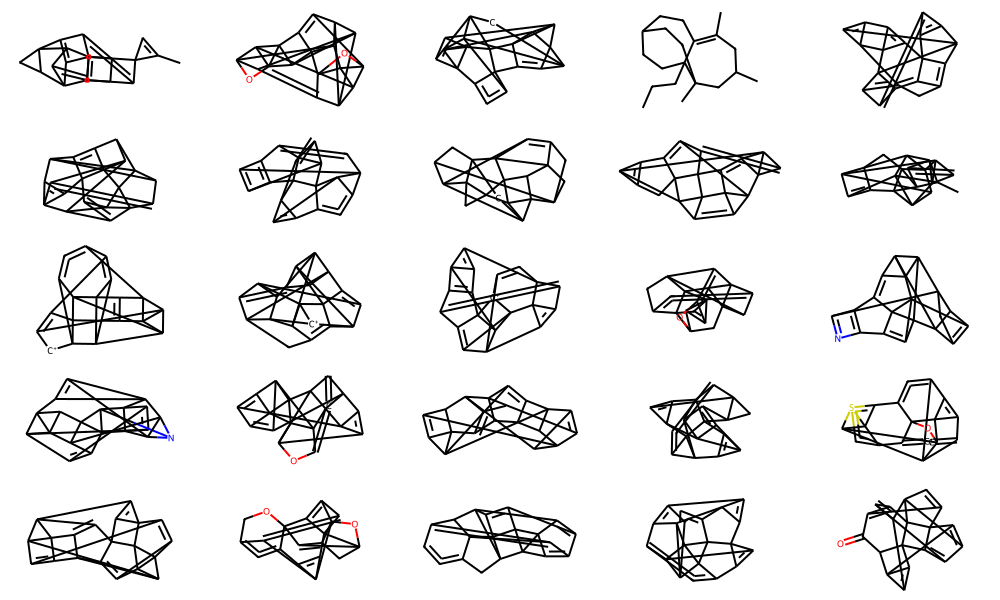

In [14]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120))#, legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

In [35]:
#ea.Tags()

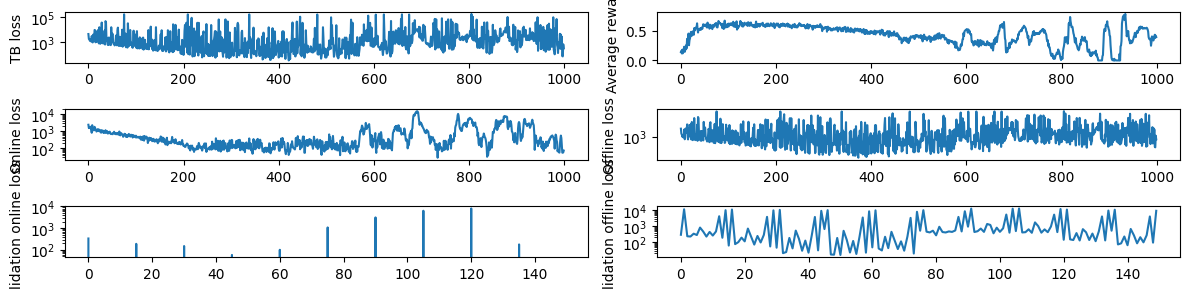

In [34]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(3, 2, figsize=(4*3,3))
ax[0,0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('TB loss')
ax[0,1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[0,1].set_ylabel('Average reward')
#ax[0,2].plot([i.value for i in ea.Scalars('train_logZ')])
#ax[0,2].set_ylabel('Predicted logZ')
ax[1,0].plot([i.value for i in ea.Scalars('train_online_loss')])
ax[1,0].set_yscale('log')
ax[1,0].set_ylabel('Online loss')
ax[1,1].plot([i.value for i in ea.Scalars('train_offline_loss')])
ax[1,1].set_yscale('log')
ax[1,1].set_ylabel('Offline loss')
ax[2,0].plot([i.value for i in ea.Scalars('valid_online_loss')])
ax[2,0].set_yscale('log')
ax[2,0].set_ylabel('Validation online loss')
ax[2,1].plot([i.value for i in ea.Scalars('valid_offline_loss')])
ax[2,1].set_yscale('log')
ax[2,1].set_ylabel('Validation offline loss')
pp.tight_layout()

In [31]:
max([i.value for i in ea.Scalars('train_sampled_reward_avg')])

0.7858443856239319

In [ ]:
cfg.log_dir+"/train/"

'./logs/dataload_2/train'

In [ ]:
!dir ./logs/dataload_2/train/

Parameter format not correct - "logs".


In [17]:
import sqlite3
import pandas as pd
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [18]:
conn = sqlite3.connect(f"{cfg.log_dir}/train/generated_objs_0.db")

In [19]:
df = pd.read_sql_query("SELECT * FROM results", conn)

In [20]:
import numpy as np

In [21]:
idx_list = sorted([j*32 -i -1  for j in [200,400,600,800,1000] for i in range(5)])

In [22]:
choosendf = df.iloc[idx_list]

In [23]:
top_rewards = df.sort_values(by='r', ascending=False).head(25)


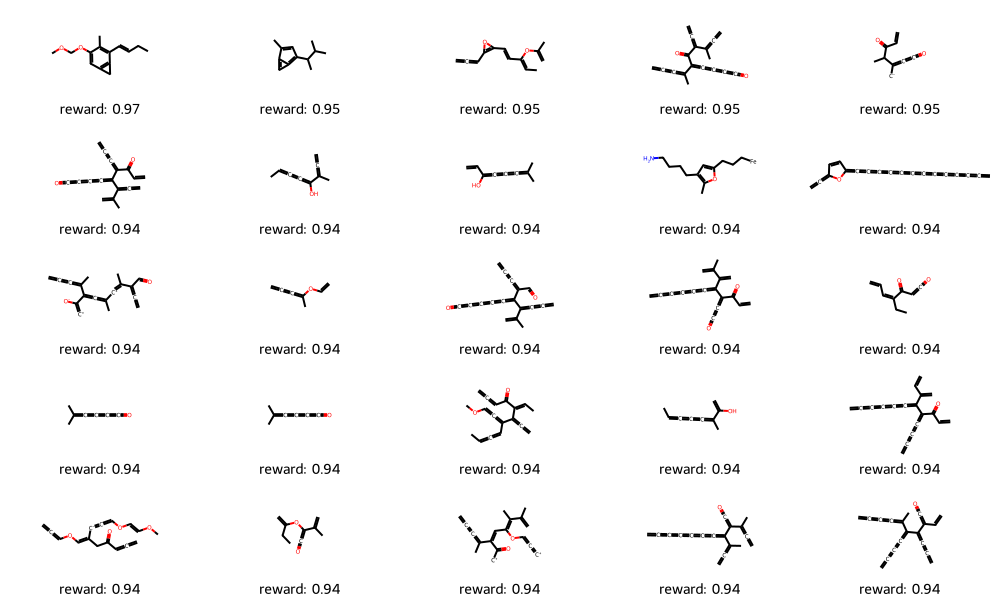

In [24]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in top_rewards["smi"]]
rewards = top_rewards["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

In [25]:
df['iteration'] = df.index // 32

# Compute mean of desired columns per iteration
# Example: mean reward per iteration
# Replace 'reward' with your actual column name
mean_per_iter = df.groupby('iteration')['r'].mean()
mean_per_iter

iteration
0      0.143044
1      0.163646
2      0.118378
3      0.181681
4      0.121008
         ...   
995    0.396688
996    0.434585
997    0.381397
998    0.418289
999    0.395667
Name: r, Length: 1000, dtype: float64

In [26]:
import matplotlib.pyplot as plt

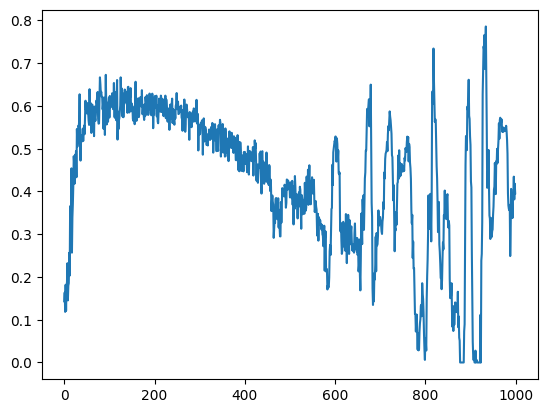

In [27]:
plt.plot(mean_per_iter)

In [28]:
from rdkit import Chem

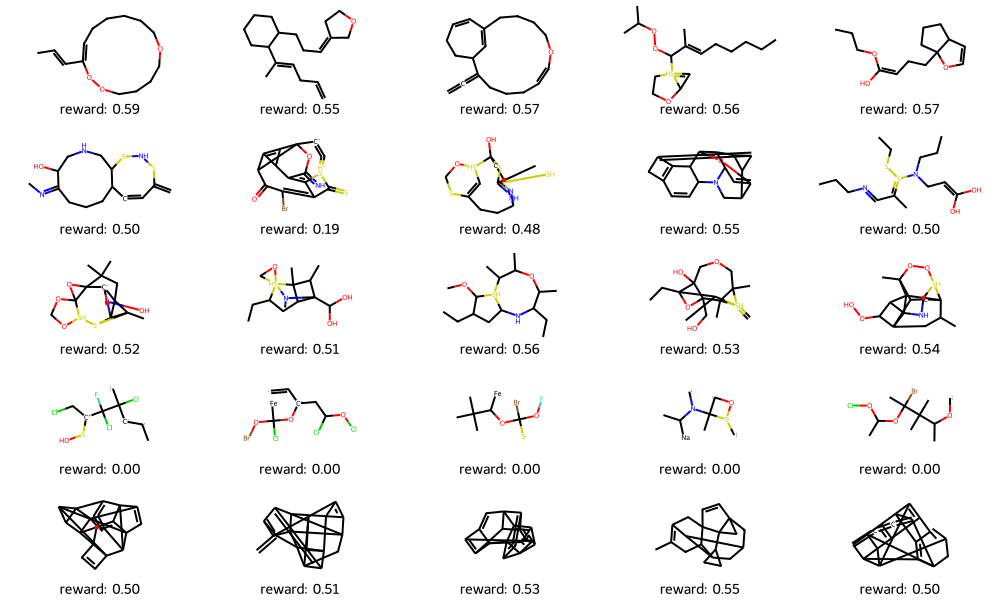

In [29]:
# Generate molecules
objs = [Chem.MolFromSmiles(smiles) for smiles in choosendf["smi"]]
rewards = choosendf["r"]


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r:.2f}' for r in rewards[:25]])

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[10], line 23
     18 config.overwrite_existing_exp=True
     22 trial = ScentTrainer(config)
---> 23 trial.run()
     24 save_run(trial)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:271, in GFNTrainer.run(self, logger)
    269 logger.info("Starting training")
    270 start_time = time.time()
--> 271 for it, batch in zip(range(start, 1 + num_training_steps), cycle(train_dl)):
    272     # the memory fragmentation or allocation keeps growing, how often should we clean up?
    273     # is changing the allocation strategy helpful?
    275     if it % 1024 == 0:
    276         gc.collect()

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\trainer.py:377, in cycle(it)
    375 def cycle(it):
    376     while True:
--> 377         for i in it:
    378             yield i

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:708, in _BaseDataLoaderIter.__next__(self)
    705 if self._sampler_iter is None:
    706     # TODO(https://github.com/pytorch/pytorch/issues/76750)
    707     self._reset()  # type: ignore[call-arg]
--> 708 data = self._next_data()
    709 self._num_yielded += 1
    710 if (
    711     self._dataset_kind == _DatasetKind.Iterable
    712     and self._IterableDataset_len_called is not None
    713     and self._num_yielded > self._IterableDataset_len_called
    714 ):

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\dataloader.py:764, in _SingleProcessDataLoaderIter._next_data(self)
    762 def _next_data(self):
    763     index = self._next_index()  # may raise StopIteration
--> 764     data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
    765     if self._pin_memory:
    766         data = _utils.pin_memory.pin_memory(data, self._pin_memory_device)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\torch\utils\data\_utils\fetch.py:42, in _IterableDatasetFetcher.fetch(self, possibly_batched_index)
     40         raise StopIteration
     41 else:
---> 42     data = next(self.dataset_iter)
     43 return self.collate_fn(data)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:80, in DataSource.__iter__(self)
     78 for d in batch_infos:
     79     batch_info.update(d)
---> 80 yield self.create_batch(trajs, batch_info)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\data\data_source.py:220, in DataSource.create_batch(self, trajs, batch_info)
    218 ci = torch.stack([t["cond_info"]["encoding"] for t in trajs])
    219 log_rewards = torch.stack([t["log_reward"] for t in trajs])
--> 220 batch = self.algo.construct_batch(trajs, ci, log_rewards)
    221 batch.num_online = sum(t.get("is_online", 0) for t in trajs)
    222 batch.num_offline = len(trajs) - batch.num_online

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in TrajectoryBalance.construct_batch(self, trajs, cond_info, log_rewards)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\algo\trajectory_balance.py:311, in <listcomp>(.0)
    307     actions = [
    308         self.ctx.GraphAction_to_ActionIndex(g, i[1]) for g, tj in zip(torch_graphs, trajs) for i in tj["traj"]
    309     ]
    310 else:
--> 311     torch_graphs = [self.ctx.graph_to_Data(i[0]) for tj in trajs for i in tj["traj"]]
    312     actions = [
    313         self.ctx.GraphAction_to_ActionIndex(g, a)
    314         for g, a in zip(torch_graphs, [i[1] for tj in trajs for i in tj["traj"]])
    315     ]
    316 batch = self.ctx.collate(torch_graphs)

File c:\Users\paulj\Desktop\Master\venv\lib\site-packages\gflownet\envs\mol_building_env.py:280, in MolBuildingEnvContext.graph_to_Data(self, g)
    277     remove_node_mask[i] = 1
    278 for k, sl in zip(self.atom_attrs, self.atom_attr_slice):
    279     # idx > 0 means that the attribute is not the default value
--> 280     idx = self.atom_attr_values[k].index(ad[k]) if k in ad else 0
    281     x[i, sl + idx] = 1
    282     if k == "v":

ValueError: 1 is not in list